# RNN for weather forecast

Task: predicting the temperature in Seattle over time, based on historical data.

In [ ]:
import numpy as np
import pandas as pd
from skorch import NeuralNetRegressor
import torch
import torch.nn as nn
import torch.optim as optim

# Load dataset
df = pd.read_csv('data/rnn/seattle-weather.csv')

df.head()


,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [18]:
df.describe()

,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000


In [ ]:
# count missing values
df.isnull().sum()

date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

In [8]:
# count duplicates
df.duplicated().sum()

np.int64(0)

In [ ]:
# temperature as training data
training_data = df.iloc[:,2:3].values
training_data

array([[12.8],
       [10.6],
       [11.7],
       ...,
       [ 7.2],
       [ 5.6],
       [ 5.6]])

In [ ]:
# Build training set.
# Use a sliding window approach to create overlapping sequences of length window_size.
# For each sequence (window), it extracts:
# - X_train: The features, consisting of window_size consecutive values from the first column of df.
# - y_train: The target value, which is the next value (immediately after the window) in the first column of df.
def df_to_XY(df, window_size=10):
    X_train = np.array([df[i - window_size:i, 0] for i in range(window_size, len(df))])
    y_train = np.array([df[i, 0] for i in range(window_size, len(df))])
    return X_train, y_train


X,y = df_to_XY(training_data)
print(len(X),len(y))

# split into training, validation and test (do not use shuffling)
X_train = X[:800]
y_train = y[:800]
X_val = X[800:1000]
y_val = y[800:1000]
X_test = X[1000:]
x_test = y[1000:]

1451 1451


In [11]:
print(X_train.shape, y_train.shape)

(800, 10) (800,)


In [12]:
X_train = torch.tensor(np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1)), dtype=torch.float32)
X_val = torch.tensor(np.reshape(X_val,(X_val.shape[0],X_val.shape[1],1)), dtype=torch.float32)
X_test = torch.tensor(np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1)), dtype=torch.float32)
y_train = torch.tensor(y_train.reshape(-1,1), dtype=torch.float32)
y_val = torch.tensor(y_val.reshape(-1,1), dtype=torch.float32)

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity="relu") 
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # Take the last output for prediction
        return out

In [ ]:
input_size = X_train.shape[2]
hidden_size = 50
num_layers = 4
output_size = 1

pytorch_model = RNNModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)


In [ ]:
from skorch.helper import predefined_split
from skorch.dataset import Dataset

valid_ds = Dataset(X_val, y_val)

net = NeuralNetRegressor(
    pytorch_model,
    max_epochs=100,
    lr=0.001,
    batch_size=32,
    optimizer=optim.Adam,
    # specify a validation set instead of letting skorch choose it
    train_split=predefined_split(valid_ds)
)

net.fit(X_train, y_train)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1      241.4820       21.8801  0.1489
      2       28.4368       20.2996  0.0634
      3       14.7240       32.5236  0.0631
      4       16.1252       20.9040  0.0612
      5       14.7058       23.2919  0.0624
      6       14.9063       22.5451  0.1002
      7       14.6370       23.7092  0.0621
      8       14.5764       22.0595  0.0616
      9       14.8813       22.4577  0.0616
     10       14.2117       22.1485  0.0606
     11       13.6921       22.6233  0.0603
     12       13.7407       20.6065  0.0608
     13       13.0367       21.9713  0.0607
     14       13.1667       20.7861  0.0608
     15       12.6448       21.3729  0.0601
     16       12.5086       22.3041  0.0612
     17       12.6558       18.2017  0.0609
     18       11.5498       17.3905  0.0607
     19       10.8660       18.8865  0.0604
     20       11.1188       16.2987  0.0608
     21       10.1936       15.5

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=RNNModel(
    (rnn): RNN(1, 50, num_layers=4, batch_first=True)
    (fc): Linear(in_features=50, out_features=1, bias=True)
  ),
)

In [16]:
train_pred = net.predict(X_train).flatten()
val_pred = net.predict(X_val).flatten()
test_pred = net.predict(X_test).flatten()

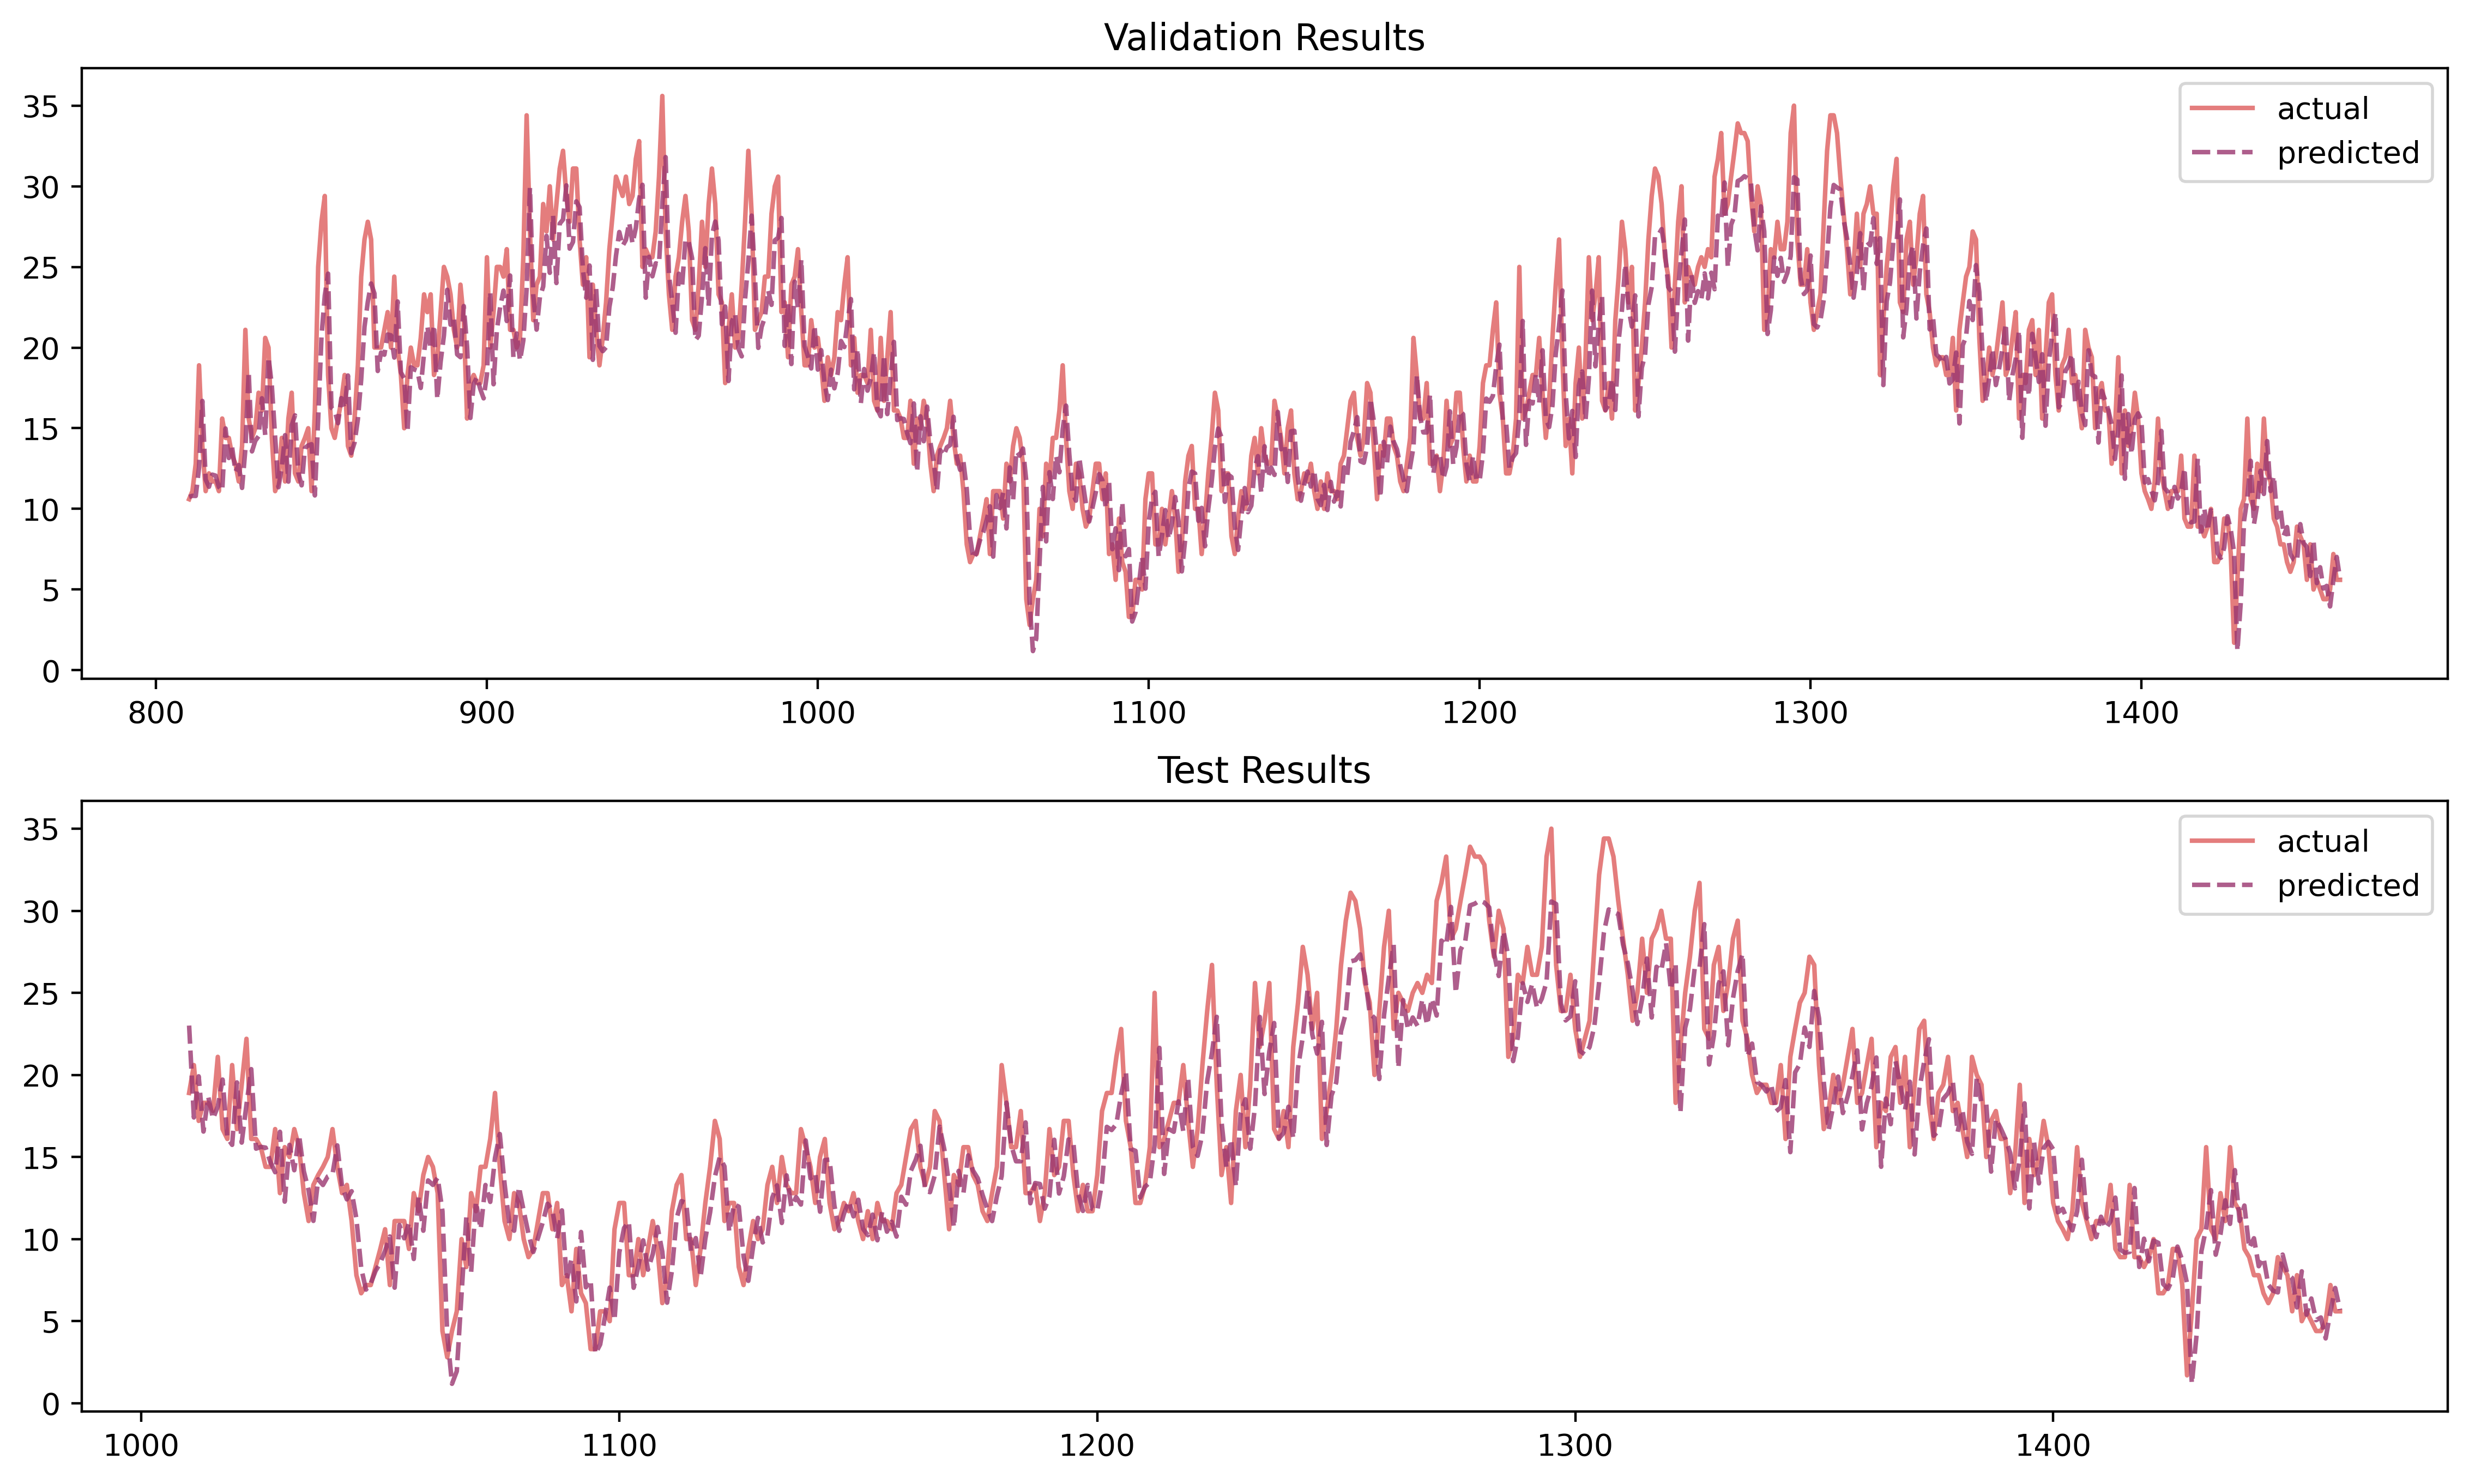

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

pred = np.concatenate([train_pred,val_pred,test_pred])
df_pred = pd.DataFrame(df["temp_max"].copy())
df_pred.columns=["actual"]
df_pred = df_pred[10:]
df_pred["predicted"] = pred

fig,axes = plt.subplots(2,1,figsize=(14,8),dpi=400)

plt.subplot(2,1,1)
plt.title("Validation Results")
sns.lineplot(df_pred[800:],alpha=0.8,palette="flare",linestyle=None);

plt.subplot(2,1,2)
plt.title("Test Results")
sns.lineplot(df_pred[1000:],alpha=0.8,palette="flare",linestyle=None);